In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re
from time import sleep

In [4]:

def extractDescConfig(page):
    '''Extract the description and the config json from the page
    :param page: The web page
    :type page: bs4.BeautifulSoup
    :return: The description and the parsed config json
    :rtype: string, dict
    
    Reused Code From
    https://github.com/alexmerkel/tsarchiver/blob/main/subconvert.py
    '''
    #Extract description
    desc = page.body.find("div", attrs={"class" : "copytext__video__details"}).find('p').text.strip()
    #Extract config
    config = page.body.find("div", attrs={"class" : "ts-mediaplayer"})["data-config"]
    config = json.loads(config)
    return desc, config

def generateStringFromRawSubs(subtitles):

    '''
    Reused Code From
    subconverter - convert subtitles to the SRT format
    https://github.com/alexmerkel/tsarchiver/blob/main/subconvert.py
    '''
    lines = []
    base = BeautifulSoup(subtitles, "html.parser")
    div = base.find("tt:div")
    p = "tt:p"
    if not div:
        div = base.find("div")
        p = "p"
    for p in div.find_all(p):
        #Loop through items inside p
        par = []
        for item in p.findChildren():
            #span element: text
            if "span" in item.name: par.append(item.text)
            #br: insert line break
            elif "br" in item.name: par.append("\n")
        if par: lines.append(''.join(par))
    return "\n\n".join(lines)


def getTranscript(config):
    # Finde und parse Untertitel
    global b
    try:
        subtitleURL = config["mc"]["_subtitleUrl"]
    except KeyError:
        return ""
    if not subtitleURL.startswith("http"):
        subtitleURL = "https://www.tagesschau.de" + subtitleURL
    r = requests.get(subtitleURL)
    r.raise_for_status()
    rawSubs = r.text
    transcript = generateStringFromRawSubs(rawSubs)
    sleep(3)
    return transcript

def loadPage(tagesschauURL):
    # lade und parse tagesschauURL
    r = requests.get(tagesschauURL, allow_redirects=False)
    if r.status_code != 200: return None
    return BeautifulSoup(r.text, features="html.parser")

def extractDate(config):
    # Finde Datum der Tagesschau in config des Videos
    try:
        datetime = config["mc"]["_info"]["clipDate"]
    except KeyError:
        return None
    match = re.search("(\d?\d\.\d?\d\.\d\d\d\d)", datetime)
    if match: return match.group(1).replace('.','-')
    return None

def extractDateTranscript(transcript):
    # Finde Datum der Tagesschau in Untertiteln
    if transcript:
        match =  re.search("\((\d?\d\.\d?\d\.\d\d\d\d)\)", transcript)
        if match: return match.group(1).replace('.','-')
    return None
    
def processTagesschau(tagesschauURL):
    # Finde Untertitel und Beschreibung in tagesschauURL
    page = loadPage(tagesschauURL)
    if not page or not page.title or '20:00' not in  page.title.text: return None
    desc, config = extractDescConfig(page)
    transcript = getTranscript(config)
    date = extractDateTranscript(transcript)
    if not date: date = extractDate(config)
    
    if desc and transcript and date: return {'topics':desc, 'date':date, 'transcript':transcript}
    return {}

def saveTagesschau(info):
    # speichere Untertitel-Text der Tagesschau
    if not info: return False
    with open(f"./Data/Tagesschau_{info['date']}.json", 'w', encoding="utf-8") as f:
        json.dump(info, f, ensure_ascii=False)
    return True

def runProcess(start, end):
    # crawl the Tagesschau Sendungs-Archiv, beginning at ID=start, end at ID=end
    successCount = 0
    for i in range(start, end+1):
        tagesschauURL = f"https://www.tagesschau.de/multimedia/sendung/ts-{i}.html"
        info = processTagesschau(tagesschauURL)
        if info:
            info['index'] = i
            success = saveTagesschau(info)
            if success:
                successCount += 1
                print(f"Saved Tagesschau {info['date']} ({tagesschauURL}), {successCount} completed")
            else: print(f"Couldn't save Tagesschau ({tagesschauURL})")
        else:
            print(f"    Tagesschau not found ({tagesschauURL})")
        sleep(2.1)

In [ ]:
#runProcess(132, 241)
#runProcess(242, 43133)
#runProcess(3004, 43133)
#runProcess(3297, 43133)
#runProcess(3384, 43133)
#runProcess(3776, 43133)https://www.tagesschau.de/multimedia/sendung/ts-42307.html
#runProcess(42307, 43133)
#runProcess(9689, 42293)
#runProcess(14919, 42293)
#runProcess(18105, 42293)
#runProcess(20399, 42293)
#runProcess(21567, 42293)
#runProcess(22545, 42293)
#runProcess(23011, 42293)
#runProcess(24001, 42293)
#runProcess(28877, 28877)https://www.tagesschau.de/multimedia/sendung/ts-33221.html
#runProcess(29323, 42293)
#runProcess(33221, 42293)
#runProcess(35883, 42293)
#runProcess(36219, 42293)
#runProcess(37097, 42293)
#runProcess(40511, 42293)
#runProcess(43191, 43623)
runProcess(43207, 43623)

# Evaluate completeness & visualize

In [1]:
import os, re

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [16]:
fontsize = 26
plt.rcParams["font.family"] = 'PT Sans','Noto Sans', 'Noto Serif'
plt.rcParams["xtick.labelsize"] = fontsize*0.8
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["legend.fontsize"] = fontsize
plt.rcParams["ytick.major.pad"] = 10
plt.rcParams["xtick.major.pad"] = 10
plt.rcParams["ytick.major.width"] = 0
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.color"] = 'white'
plt.rcParams["xtick.major.width"] = 1

In [4]:
parsed_dates = set()

DATE_PATTERN = re.compile("Tagesschau_(.*).json")
for file in os.listdir("./Data/"):
    if file.endswith('.json'):
        match = DATE_PATTERN.search(file)
        if match: parsed_dates.add(match.group(1))
        else: print(f"Date not found in file name: {file}")

In [5]:
from datetime import timedelta, date

success = 2408, failed = 149, of 2557


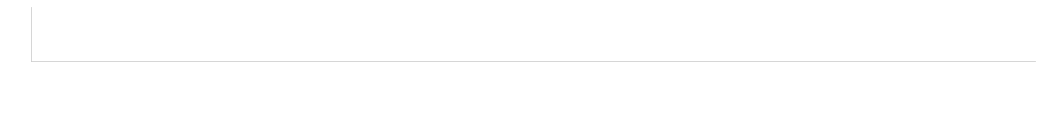

In [20]:
def daterange(start, end):
    for n in range(int((end - start).days)+1):
        yield start + timedelta(days=n)

start = date(2014, 6, 1)
end = date(2021, 5, 31)
xticks = {}

fig, ax = plt.subplots(figsize=(18,1))
success, failed = 0, 0
for i, dt in enumerate(daterange(start, end)):
    if not dt.month % 6 and dt.day == 1: xticks[i] = dt.strftime("%b\n%Y")
    if dt.strftime("%d-%m-%Y") in parsed_dates:
        success +=1
        ax.bar(i, 1, width=1, color='white', align='edge', linewidth=0)
    else:
        failed +=1
        ax.bar(i, 1, width=1, color='green', align='edge', linewidth=0, alpha=0)
        
ax.set_xlim(left=0, right=2557)
ax.set_ylim(top=1)
ax.set_yticklabels(())
ax.set_xticks(list(xticks))
ax.set_xticklabels([xticks[k] for k in xticks], color='white')
sns.despine()
ax.grid(False)
print(f"success = {success}, failed = {failed}, of {success+failed}")

plt.savefig("Gefundene_Sendungen.png",dpi=600, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [6]:
2408/2557

0.9417285881892843